In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

## Calculating Dark Channel

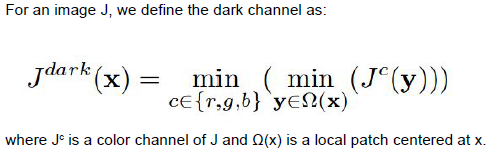

In [2]:
def calculate_DCP(img, wind_size):
    """
    calculates the dark channel prior for the input image
    it select the pixel having low intensity within the patch
    cv2.copyMakeBorder() method is used to create a border around the image like a photo frame
    cv2.copyMakeBorder(src, top, bottom, left, right, borderType, value)
    """
    dcp = np.zeros((img.shape[0], img.shape[1]))
    border_size = wind_size//2
    img = cv2.copyMakeBorder(img, 
                           border_size,
                           border_size,
                           border_size,
                           border_size,
                           cv2.BORDER_CONSTANT, 
                           value=[255, 255, 255])
    num_rows = img.shape[0]
    num_cols = img.shape[1]
    min_channel = np.zeros((num_rows, num_cols))

    for row in range(num_rows):
        for col in range(num_cols):
            min_channel[row-border_size][col-border_size] = np.min(img[row, col, :]) #finds the minimum intensity in each channel

    for row in range(border_size, num_rows-border_size):
        for col in range(border_size, num_cols-border_size):
              dcp[row-border_size][col-border_size] = np.min(min_channel[row-border_size:row+border_size, col-border_size:col+border_size]) #calculates dark channel prior

    return dcp

## Estimating Atmospheric Light


In [3]:
def calculate_ambience(im, dc_img,flag):
    """
    Returns atmospheric ambience(brightness paramater "A")
    input -
    im  = original Image
    dc_img = dark channel prior of the orirginal image
    """
    img = im.copy()
    pixel_count = dc_img.size
    # print(pixel_count)
    count_brightest = pixel_count//1000  # pick the top 0.1% brightest pixels in the dark channel
    haze_density_sort_idx = np.argsort(dc_img, axis=None)[::-1]
    brightest = haze_density_sort_idx[0:count_brightest]
    brightest = np.unravel_index(brightest,dc_img.shape)
    brightest_pixels = img[brightest]
    top_intensities = np.average(brightest_pixels, axis=1)
    max_intensity = np.argmax(top_intensities) #finds maximum among the brightest pixel
    A = brightest_pixels[max_intensity]

    # to display the brightest pixels in the image
    img[brightest]=[255,0,0]
    row_min = np.min(brightest[0])
    row_max = np.max(brightest[0])
    col_min = np.min(brightest[1])
    col_max = np.max(brightest[1])

    # mark the brightest region in the image
    cv2.rectangle(img, 
                (col_min,row_min),
                (col_max,row_max),
                (0,0,255),
                thickness=2)
    if flag :
        plt.figure(figsize=(10,10))
        plt.imshow(img[...,::-1])
        plt.show()
    return A

In [4]:
def filter_image(img, transmission, filter_size, epsilon):
    """
    smoothen the input image(transmssion map) using guided filter.
    input -
    img = original image
    transmission = transmission t(x)
    filter_size = width of the guided filter
    epsilon  =  constant value

    output -
    q = egde preserved smoothen image

    """
    guide = cv2.blur(img,(filter_size,filter_size)) #smoothen the guiding image
    trans = cv2.blur(transmission,(filter_size,filter_size)) # smoothen the transmission map
    gt = cv2.blur(img * transmission, (filter_size,filter_size))

    a = gt - guide * trans
    var_guide = cv2.blur(img * img,(filter_size,filter_size)) - (guide *guide)
    a = a/(var_guide + epsilon)
    b = trans - a * guide

    q = cv2.blur(a,(filter_size,filter_size)) * img + cv2.blur(b,(filter_size,filter_size))
    return q

## Recovering Scene Radiance
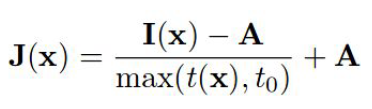

In [5]:
def recover_image(img, trans_bar, atm_light, t0):
    """
    recover original image
    input -
    img = original image
    trans_bar = transmission map for hazed image
    atm  = atmospheric brightness A
    t0 = lower bound for t(x)

    output -
    j = dehazed image


    """
    trans_recover = np.copy(trans_bar)
    trans_recover[trans_recover < t0] = t0
    J = np.zeros((img.shape))

    J[:,:,0] = ((img[:,:,0] - atm_light[0])/trans_recover) + atm_light[0] #recovery got R channel
    J[:,:,1] = ((img[:,:,1] - atm_light[1])/trans_recover) + atm_light[1] #recovery for G channel
    J[:,:,2] = ((img[:,:,2] - atm_light[2])/trans_recover) + atm_light[2] #reovery for B channel

    return J


## Color Correction


In [6]:
def color_balance(img, s):
    """
    since the haze removal also affects the brightness
    it enhance the color saturation of the dehazed image
    """
    out = np.copy(img)
    hist = np.zeros((256,1))
    no_of_pixels = img.shape[0] * img.shape[1]

    for i in range(3):
        channel_vals = img[:,:,i]

    for pixel_val in range(256):
        hist[pixel_val] = np.sum((channel_vals == pixel_val)) 
    for pixel_val in range(256):
        hist[pixel_val] = hist[pixel_val-1] + hist[pixel_val]

    # clipping pixels
    Vmin = 0
    while (Vmin < 255 and hist[Vmin] <= no_of_pixels*s):
        Vmin += 1
    Vmax = 255
    
    while (Vmax > 0 and hist[Vmax] > no_of_pixels*(1-s)):
        Vmax -= 1
    
    channel_vals[channel_vals < Vmin] = Vmin
    channel_vals[channel_vals > Vmax] = Vmax

    # normalize pixel values
    out[:,:,i] = cv2.normalize(channel_vals, channel_vals.copy(), 0, 255, cv2.NORM_MINMAX)
    return out

## Calculate Depth Map

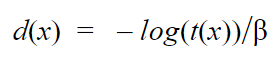

In [7]:
def depth_map(t_refine, beta):
    """
    function to plot the depth map of the image 
    to find how distant an object in image actually is
    """
    x = -np.log(t_refine)/beta
    return x

In [8]:

def histEqual(im):
    """ histogram equalization method for comparison """
    ycrcb = cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)
    ycrcb[:,:,0] = cv2.equalizeHist(ycrcb[:,:,0])
    restored = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
    return restored

## Processing Image

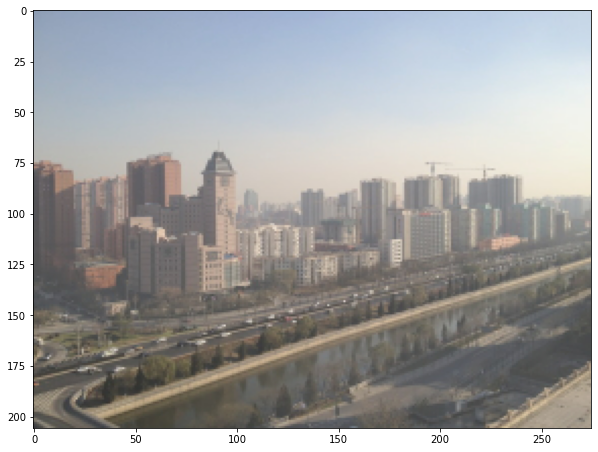

In [9]:
# Input Image
filename = "Std_Dataset/synthetic/0586.jpg"
img = cv2.imread(filename)
img = cv2.resize(img,(0,0),fx=0.5,fy=0.5)
plt.figure(figsize=(10,10))
plt.imshow(img[...,::-1])
plt.show()

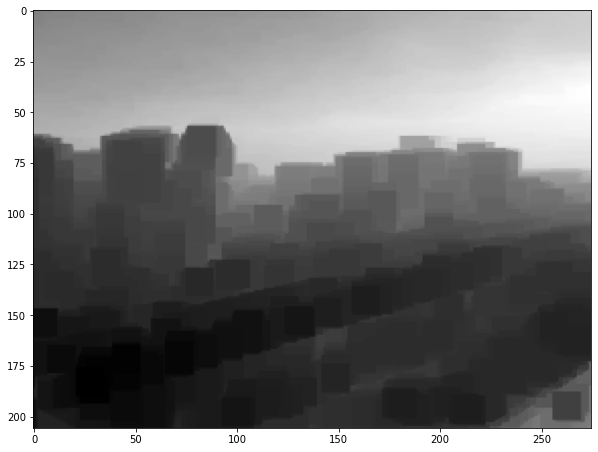

In [10]:
# Show dark channel in image
dcp_img = calculate_DCP(img, 15)
dcp_img = dcp_img.astype('uint8')
plt.figure(figsize=(10,10))
plt.imshow(dcp_img,'gray')
plt.show()

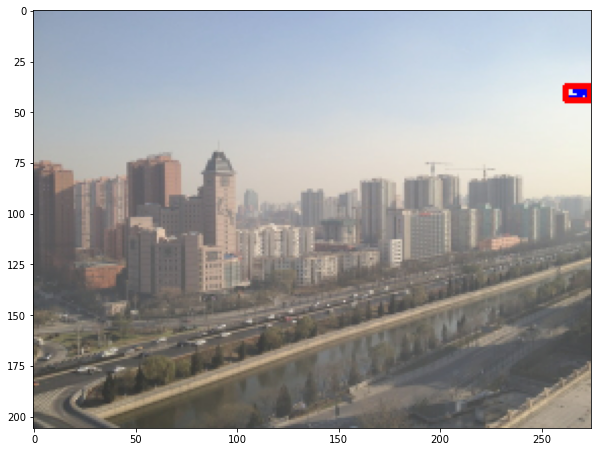

In [11]:
# Plot the atmospheric light in image
# Red region
atm_light = calculate_ambience(img, dcp_img,1)

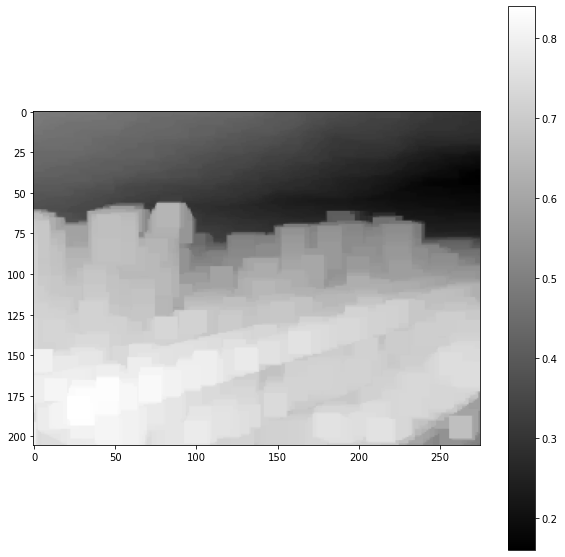

In [12]:
# Plot Emission Transmission Map
# amt of light reaching the camera
t_bar = calculate_DCP(img/atm_light,15)
trans_bar = 1-(0.85*t_bar)
plt.figure(figsize=(10,10))
plt.imshow(trans_bar,'gray')
plt.colorbar()
plt.show()

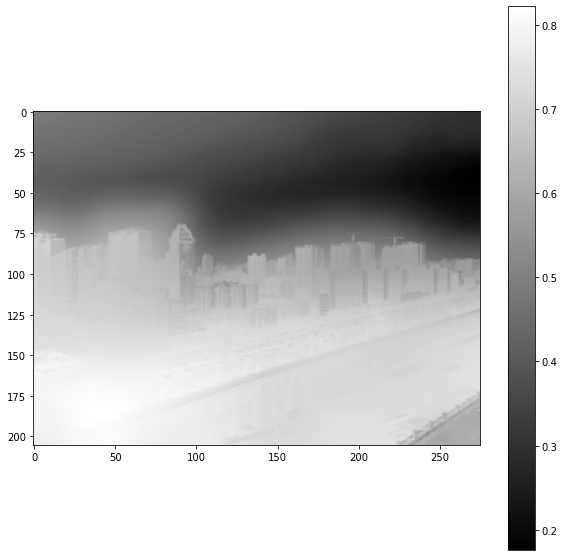

In [13]:
# Refining the transmission map with a guided filter
i=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)/255
t_refine = filter_image(i, trans_bar, 30, 0.0001)
plt.figure(figsize=(10,10))
plt.imshow(t_refine,'gray')
plt.colorbar()
plt.show()

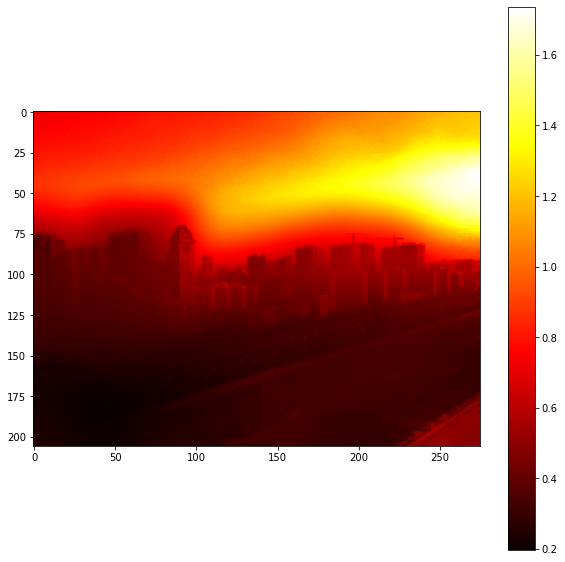

In [14]:
# Depth map
# To show regions near (darker) and Far away (Lighter)
plt.figure(figsize=(10,10))
plt.imshow(depth_map(t_refine, 1),'hot')
plt.colorbar()
plt.show()

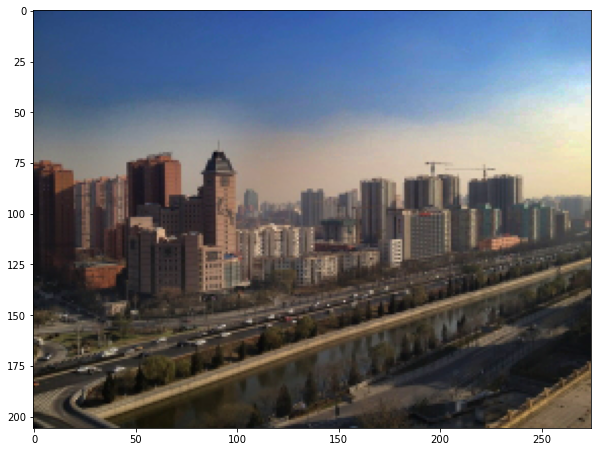

In [15]:
# Output after restoring image
im = img.astype("double")
J = recover_image(im, t_refine, atm_light, 0.1)
J = ((J-np.min(J))/(np.max(J)-np.min(J)))*255
plt.figure(figsize=(10,10))
plt.imshow((np.uint8(J[...,::-1])))
plt.show()

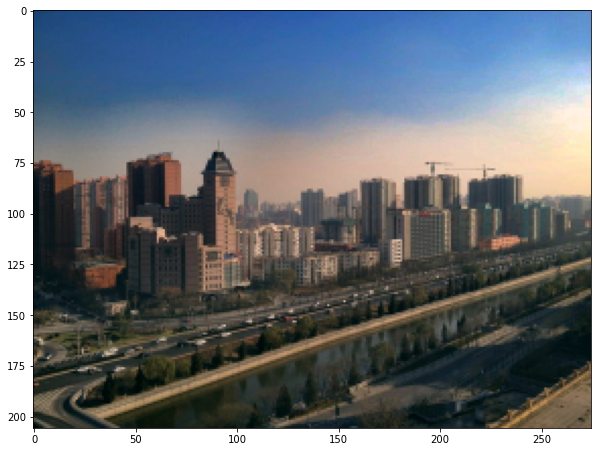

In [16]:
# Output after color correction
cb_J = color_balance(np.uint8(J),0.005)
plt.figure(figsize=(10,10))
plt.imshow((np.uint8(cb_J[...,::-1])))
plt.show()

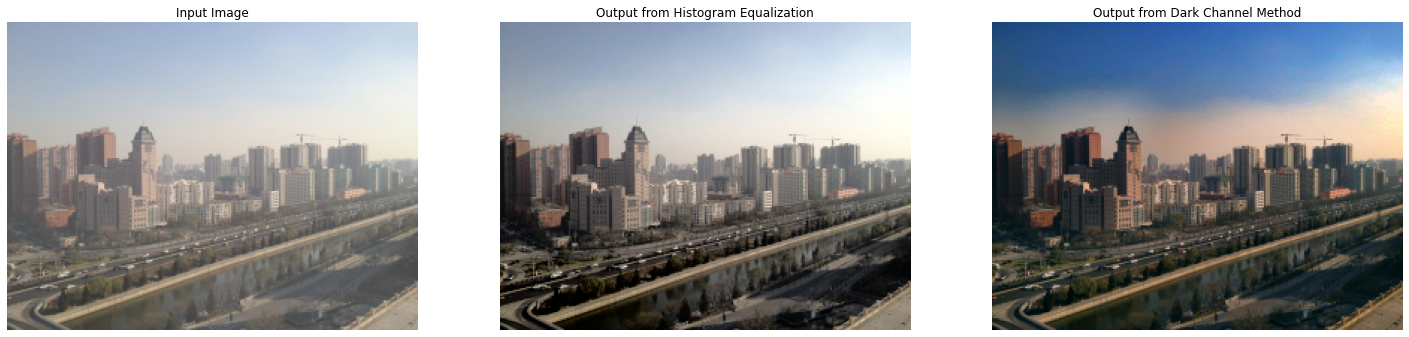

In [17]:
J = histEqual(img)

fig=plt.figure(figsize=(25,15))
ax=fig.add_subplot(131)
ax.imshow(img[...,::-1])
ax.set_title("Input Image")
ax.axis('off')

ax=fig.add_subplot(132)
ax.imshow(J[...,::-1])
ax.set_title("Output from Histogram Equalization")
ax.axis('off')

ax=fig.add_subplot(133)
ax.imshow(cb_J[...,::-1])
ax.set_title("Output from Dark Channel Method")
ax.axis('off')
plt.show()

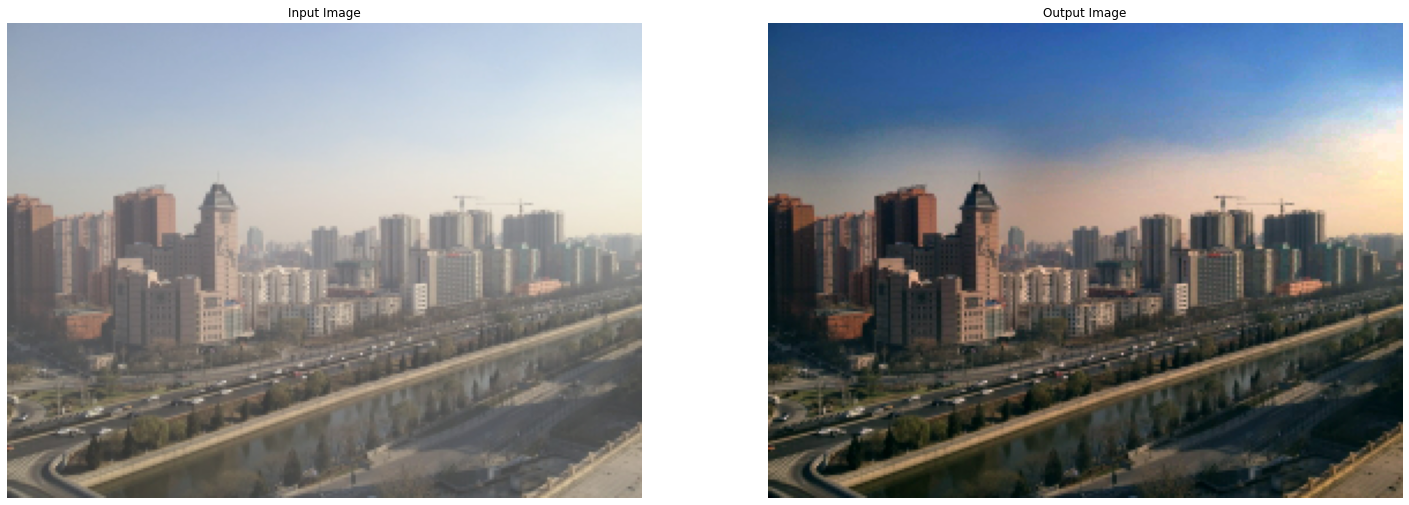

In [18]:
fig=plt.figure(figsize=(25,15))
ax=fig.add_subplot(121)
ax.imshow(img[...,::-1])
ax.set_title("Input Image")
ax.axis('off')

ax=fig.add_subplot(122)
ax.imshow(cb_J[...,::-1])
ax.set_title("Output Image")
ax.axis('off')
plt.show()

In [19]:
# name = filename.split('.')[0]
# fig.savefig('./output0/'+name+'_op.png', transparent=True, dpi=fig.dpi)

In [20]:
def run(im_path, omega, t0, radius, dark_rad,gt_path = False):
    """
    Main function to produce dehazed Image
    input -
    gt_path = path to the input image
    im_path  = path to the original image
    omega  = value of omega for t(x)
    t0 = lower bound for t(x)
    radius = patch size of guided filter
    dark_rad = patch size of DCP calculator
    """
    img = cv2.imread(im_path)
    dc_img = calculate_DCP(img, dark_rad)
    dc_img = dc_img.astype('uint8')
    atm_light = calculate_ambience(img,dc_img,0)
    t_bar = calculate_DCP(img/atm_light,dark_rad)
    trans_bar = 1-(omega * t_bar)
    i=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)/255
    t_refine = filter_image(i, trans_bar, radius, 0.0001)
    im = img.astype("double")
    J = recover_image(im, t_refine, atm_light, t0)
    J = ((J-np.min(J))/(np.max(J)-np.min(J)))*255
    cb_J = color_balance(np.uint8(J),0.005)
    if gt_path:
        gt = cv2.imread(gt_path)
        E = np.sum((cb_J-gt)**2)/gt.size
        return (10*np.log10(255*255/E))
    else:
        return img,cb_J

In [21]:
gt = next(os.walk('Std_Dataset/original'))[2]
gt.sort()
hazy = next(os.walk('Std_Dataset/synthetic/'))[2]
hazy.sort()

In [22]:
def line_plot(x,y,xlabel,ylabel,title):
    plt.plot(x,y,marker ='o')
    plt.scatter(x[y.index(max(y))],max(y),c = 'r',
               linewidth = 2,marker ="o",s = 200)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show() 

In [23]:
win_filter = np.arange(3,40,4)
psnr_win = []
for win in win_filter:
    p = 0
    for i in range(len(gt)):
        p += run(os.path.join('Std_Dataset/synthetic',hazy[i]),0.5,0.1,30,win,os.path.join('Std_Dataset/original',gt[i]))

    psnr_win.append(p/len(gt))
print(win_filter[psnr_win.index(max(psnr_win))])

39


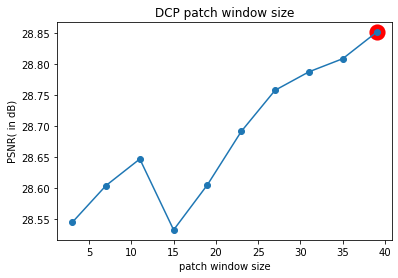

In [24]:
line_plot(win_filter,psnr_win,"patch window size","PSNR( in dB)","DCP patch window size")

In [26]:
filter_rd = np.arange(10,101,10)
psnr_filter = []
for rd in filter_rd:
    p = 0
    for i in range(len(gt)):
        p += run(os.path.join('Std_Dataset/synthetic',hazy[i]),0.5,0.1,rd,39,os.path.join('Std_Dataset/original',gt[i]))

    psnr_filter.append(p/len(gt))
print(filter_rd[psnr_filter.index(max(psnr_filter))])

80


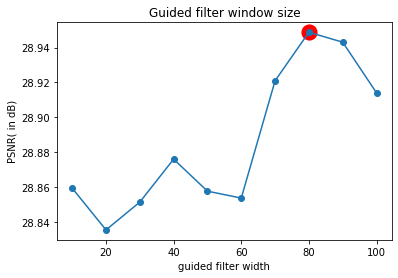

In [27]:
line_plot(filter_rd,psnr_filter,"guided filter width","PSNR( in dB)","Guided filter window size")

In [28]:
omega = np.arange(0,1.01,0.05)
psnr_omega = []
for om in omega:
    p = 0
    for i in range(len(gt)):
        p += run(os.path.join('Std_Dataset/synthetic',hazy[i]),om,0.1,80,39,os.path.join('Std_Dataset/original',gt[i]))

    psnr_omega.append(p/len(gt))
print(omega[psnr_omega.index(max(psnr_omega))])

0.1


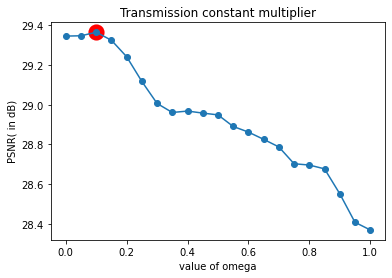

In [29]:
line_plot(omega,psnr_omega,"value of omega","PSNR( in dB)","Transmission constant multiplier")

In [32]:
t0 = np.arange(0,1.01,0.1)
psnr_t = []
for t in t0:
    p = 0
    for i in range(len(gt)):
        p += run(os.path.join('Std_Dataset/synthetic',hazy[i]),0.1,t,80,39,os.path.join('Std_Dataset/original',gt[i]))

    psnr_t.append(p/len(gt))
print(t0[psnr_t.index(max(psnr_t))])

0.0


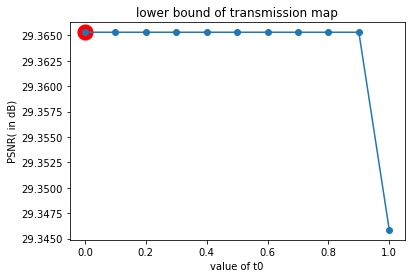

In [33]:
line_plot(t0,psnr_t,"value of t0","PSNR( in dB)","lower bound of transmission map")

In [35]:
def batch_process_img(path):
    """
    store the dehazed image into output folder
    """
    dir_path='Std_Dataset\synthetic'
    img_arr = next(os.walk(dir_path))[2]
    
    for img in img_arr:
        imgn = os.path.join(dir_path,img)
        ip_img, op_img = run(imgn, 0.1, 0.0, 50, 30)

        cv2.imwrite(os.path.join(path,img), op_img)


In [37]:
path = r'C:\Users\Chandan\Desktop\DIP Project\Std_Dataset\output' #path to output file
batch_process_img(path)